# <font color="Blue">Telecom Churn - Group Case Study</font>

### <font color="Brown">Problem Statement :  Build predictive models to identify customers at high risk of churn and identify the main indicators of churn.</font>

#### <font color="Brown">In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.For many incumbent operators, retaining high profitable customers is the number one business goal.To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.</font>

### 1. Importing Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import math
import random
import datetime
import regex as re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

C:\Users\Andiz\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [3]:
#Setting the various display options for easier visualization of all the columns
pd.options.display.max_info_columns=500
pd.options.display.max_columns=500
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

In [4]:
#Importing the dataset
path='telecom_churn_data.csv'
data=pd.read_csv(path)

### 2. Common Functions

In [5]:
#This functions prints a datastructure

def display_data(header,data):
    print(header)
    print('-'*len(header))
    
    for detail in data:
        print(detail)
        
    print()

In [6]:
#This functions finds the missing data columns

def find_missing_data(data, cols_to_analyze):
    missing_value_cols={}
    for col in cols_to_analyze:
        missing_data_percentage=round(data[col].isnull().sum()*100/len(data.index),2)
        if missing_data_percentage != 0:
            missing_value_cols[col]=missing_data_percentage

    print('Total columns with missing data', len(missing_value_cols))
    return missing_value_cols

In [7]:
#This function draws the required graph by taking the various parameters needed for plotting a graph

def plot_graph(total_plots,plots_in_row,current_plot_number,plot_type,plot_title,data,x_value='',y_value='',width=8,height=6):
            
    sns.set_context("paper", font_scale = 1.2, rc={"grid.linewidth": 0.6})
    if plots_in_row==1:        
        plot_size=(width,height)
        figure=plt.figure(current_plot_number,plot_size)        
    else:
        plot_size=(width*plots_in_row,height*math.ceil(total_plots/plots_in_row))
        figure=plt.figure(1,plot_size)
        figure.add_subplot(math.ceil(total_plots/plots_in_row),plots_in_row,current_plot_number)
        
    plot_title=str(current_plot_number)+'. '+plot_title.upper()
    plt.title(plot_title)
    
    if plot_type=='count':
        sns.countplot(data[x_value])
        
    elif plot_type=='dist':
        sns.distplot(data[x_value])
    
    elif plot_type=='heatmap':
        plot_data=round(data.corr(),2)
        sns_plot=sns.heatmap(plot_data,annot=True,linewidths=.1,cmap='YlGnBu')
    
    plt.subplots_adjust(hspace=0.5,wspace=0.5)

In [8]:
def build_model(pipeline, hyper_params, scoring_method, x_train, y_train, x_test, y_test):
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    
    model = GridSearchCV(estimator=pipeline, param_grid=hyper_params, cv=folds, 
                         scoring=scoring_method, verbose=1, return_train_score=True, n_jobs=-1)

    model.fit(x_train, y_train)
    scores = pd.DataFrame(model.cv_results_)
    
    print('Best Score', model.best_score_)
    print('Best Parameters', model.best_params_)

    # Predicting on test data
    y_pred = model.predict(x_test)
    
    # Getting the model evaluation parameters
    print('\nConfusion Matrix')
    cm=confusion_matrix(y_test, y_pred)
    display(cm)
    print('\nClassification Report')
    print(classification_report(y_test, y_pred))
    y_pred_prob = model.predict_proba(x_test)[:, 1]
    print('\nAUC Score')
    print(round(roc_auc_score(y_test, y_pred_prob),2))
    
    return model, scores, cm

### 3. Cleaning Data

In [9]:
data.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109            0.00            0.00            0.00   
1     7001865778        109            0.00            0.00            0.00   
2     7001625959        109            0.00            0.00            0.00   
3     7001204172        109            0.00            0.00            0.00   
4     7000142493        109            0.00            0.00            0.00   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9  arpu_6  arpu_7  arpu_8  arpu_9  onnet_mou_6  \
0            9/30/2014  197.38  214.82  213.80   21.10          nan   
1            9/30/2014   34.05  355.07  268.32   86.28        24.11   
2            9/30/2014  167.69  189.06  210.23  290.71        11.54   
3            9/30/2014  221.34  251.10  508.05  389.50        99.91   
4            9/30/2014  261.64  309.88  238.17  163.43        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          nan         0.00          nan           nan           nan   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           nan            nan            nan           0.00   
1        304.76         53.76           0.00           0.00           0.00   
2        208.36        118.91           0.00           0.00           0.00   
3         71.68        113.54           0.00          54.86          44.38   
4        124.26         45.81           0.00           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            nan            nan            nan           0.00            nan   
1           0.00           0.00           0.00           0.00           0.00   
2          38.49           0.00           0.00           0.00          70.94   
3           0.00           0.00          28.09          39.04           0.00   
4           0.00           0.00           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               nan               nan              0.00               nan   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               nan               nan              0.00               nan   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               nan               nan              0.00               nan   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              4.91              2.06  

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
mobile_number               99999 non-null int64
circle_id                   99999 non-null int64
loc_og_t2o_mou              98981 non-null float64
std_og_t2o_mou              98981 non-null float64
loc_ic_t2o_mou              98981 non-null float64
last_date_of_month_6        99999 non-null object
last_date_of_month_7        99398 non-null object
last_date_of_month_8        98899 non-null object
last_date_of_month_9        98340 non-null object
arpu_6                      99999 non-null float64
arpu_7                      99999 non-null float64
arpu_8                      99999 non-null float64
arpu_9                      99999 non-null float64
onnet_mou_6                 96062 non-null float64
onnet_mou_7                 96140 non-null float64
onnet_mou_8                 94621 non-null float64
onnet_mou_9                 92254 non-null float64
offnet_mou_6                960

<font color="Brown">As can be seen there are a total of 226 columns and there are many columns with null values in the dataset. These null values need to be handled first.</font>

In [11]:
data.describe()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count       99999.00   99999.00        98981.00        98981.00   
mean   7001207270.39     109.00            0.00            0.00   
std        695669.39       0.00            0.00            0.00   
min    7000000074.00     109.00            0.00            0.00   
25%    7000606232.50     109.00            0.00            0.00   
50%    7001204632.00     109.00            0.00            0.00   
75%    7001812030.50     109.00            0.00            0.00   
max    7002410905.00     109.00            0.00            0.00   

       loc_ic_t2o_mou   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
count        98981.00 99999.00 99999.00 99999.00 99999.00     96062.00   
mean             0.00   282.99   278.54   279.15   261.65       132.40   
std              0.00   328.44   338.16   344.47   342.00       297.21   
min              0.00 -2258.71 -2014.05  -945.81 -1899.51         0.00   
25%              0.00    93.41    86.98    84.13    62.69         7.38   
50%              0.00   197.70   191.64   192.08   176.85        34.31   
75%              0.00   371.06   365.34   369.37   353.47       118.74   
max              0.00 27731.09 35145.83 33543.62 38805.62      7376.71   

       onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
count     96140.00     94621.00     92254.00      96062.00      96140.00   
mean        133.67       133.02       130.30        197.94        197.05   
std         308.79       308.95       308.48        316.85        325.86   
min           0.00         0.00         0.00          0.00          0.00   
25%           6.66         6.46         5.33         34.73         32.19   
50%          32.33        32.36        29.84         96.31         91.73   
75%         115.59       115.86       112.13        231.86        226.82   
max        8157.78     10752.56     10427.46       8362.36       9667.13   

       offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  \
count      94621.00      92254.00       96062.00       96140.00   
mean         196.57        190.34           9.95           7.15   
std          327.17        319.40          72.83          73.45   
min            0.00          0.00           0.00           0.00   
25%           31.63         27.13           0.00           0.00   
50%           92.14         87.29           0.00           0.00   
75%          228.26        220.50           0.00           0.00   
max        14007.34      10310.76       13724.38       15371.04   

       roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  \
count       94621.00       92254.00       96062.00       96140.00   
mean            7.29           6.34          13.91           9.82   
std            68.40          57.14          71.44          58.46   
min             0.00           0.00           0.00           0.00   
25%             0.00           0.00           0.00           0.00   
50%             0.00           0.00           0.00           0.00   
75%             0.00           0.00           0.00           0.00   
max         13095.36        8464.03        3775.11        2812.04   

       roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count       94621.00       92254.00          96062.00          96140.00   
mean            9.97           8.56             47.10             46.47   
std            64.71          58.44            150.86            155.32   
min             0.00           0.00              0.00              0.00   
25%             0.00           0.00              1.66              1.63   
50%             0.00           0.00             11.91             11.61   
75%             0.00           0.00             40.96             39.91   
max          5337.04        4428.46           6431.33           7400.66   

       loc_og_t2t_mou_8  loc_og_t2t_mou_9  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count          94621.00          92254.00          96062.00         

In [12]:
# Finding the categorical and numerical value columns. 
# Marking the columns with less than 20 unique elements as new categorical columns.
# Choosing the columns with no variance or all elements as unique to be dropped as these columns will be of no use in modelling.

numerical_cols={}
categorical_cols={}
new_categorical_cols={}
cols_to_drop=[]
cols_to_analyze=[]

for col in data.columns:
    unique_values = [value for value in data[col].unique() if str(value).lower()!='nan']
            
    if len(unique_values)==1 or len(unique_values)==len(data):
        cols_to_drop.append(col)
    else:
        cols_to_analyze.append(col)
        if data[col].dtype == np.object:
            categorical_cols[col]=unique_values            
        elif len(unique_values)<20:
            new_categorical_cols[col]=unique_values
        elif data[col].dtype == np.int64 or data[col].dtype == np.float64:
            numerical_cols[col]=unique_values

if len(categorical_cols)+len(numerical_cols)+len(new_categorical_cols)+len(cols_to_drop)!=len(data.columns):
    print('Mismatch in seggregation of columns')
else:
    display_data('Columns to be dropped', cols_to_drop)
    display_data('New Categorical Columns', new_categorical_cols)
    display_data('Categorical Columns', categorical_cols)    
    display_data('Numerical Columns', numerical_cols)

Columns to be dropped
---------------------
mobile_number
circle_id
loc_og_t2o_mou
std_og_t2o_mou
loc_ic_t2o_mou
last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
last_date_of_month_9
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_og_t2c_mou_9
std_ic_t2o_mou_6
std_ic_t2o_mou_7
std_ic_t2o_mou_8
std_ic_t2o_mou_9

New Categorical Columns
-----------------------
night_pck_user_6
night_pck_user_7
night_pck_user_8
night_pck_user_9
monthly_2g_6
monthly_2g_7
monthly_2g_8
monthly_2g_9
monthly_3g_6
monthly_3g_7
monthly_3g_8
monthly_3g_9
fb_user_6
fb_user_7
fb_user_8
fb_user_9

Categorical Columns
-------------------
date_of_last_rech_6
date_of_last_rech_7
date_of_last_rech_8
date_of_last_rech_9
date_of_last_rech_data_6
date_of_last_rech_data_7
date_of_last_rech_data_8
date_of_last_rech_data_9

Numerical Columns
-----------------
arpu_6
arpu_7
arpu_8
arpu_9
onnet_mou_6
onnet_mou_7
onnet_mou_8
onnet_mou_9
offnet_mou_6
offnet_mou_7
offnet_mou_8
offnet_mou_9
roam_ic_mou_6
roam_i

In [13]:
# Checking columns for the missing data

missing_value_cols=find_missing_data(data, cols_to_analyze)

Total columns with missing data 152


In [14]:
# Analyzing the Categorical columns for missing data

for col in list(categorical_cols.keys()):
    print('\n'+col)
    print('Missing values percentage', missing_value_cols.get(col), sep=' = ')
    print('Categorical Values', categorical_cols[col], sep=' = ')
data[list(categorical_cols.keys())].head()


date_of_last_rech_6
Missing values percentage = 1.61
Categorical Values = ['6/21/2014', '6/29/2014', '6/17/2014', '6/28/2014', '6/26/2014', '6/19/2014', '6/27/2014', '6/25/2014', '6/14/2014', '6/18/2014', '6/20/2014', '6/30/2014', '6/23/2014', '6/22/2014', '6/24/2014', '6/12/2014', '6/3/2014', '6/11/2014', '6/16/2014', '6/10/2014', '6/15/2014', '6/13/2014', '6/7/2014', '6/8/2014', '6/6/2014', '6/2/2014', '6/4/2014', '6/5/2014', '6/1/2014', '6/9/2014']

date_of_last_rech_7
Missing values percentage = 1.77
Categorical Values = ['7/16/2014', '7/31/2014', '7/24/2014', '7/28/2014', '7/17/2014', '7/25/2014', '7/23/2014', '7/5/2014', '7/10/2014', '7/22/2014', '7/30/2014', '7/3/2014', '7/7/2014', '7/29/2014', '7/27/2014', '7/19/2014', '7/14/2014', '7/20/2014', '7/4/2014', '7/12/2014', '7/26/2014', '7/11/2014', '7/6/2014', '7/21/2014', '7/13/2014', '7/15/2014', '7/18/2014', '7/9/2014', '7/2/2014', '7/8/2014', '7/1/2014']

date_of_last_rech_8
Missing values percentage = 3.62
Categorical Values 

date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  \
0           6/21/2014           7/16/2014            8/8/2014   
1           6/29/2014           7/31/2014           8/28/2014   
2           6/17/2014           7/24/2014           8/14/2014   
3           6/28/2014           7/31/2014           8/31/2014   
4           6/26/2014           7/28/2014            8/9/2014   

  date_of_last_rech_9 date_of_last_rech_data_6 date_of_last_rech_data_7  \
0           9/28/2014                6/21/2014                7/16/2014   
1           9/30/2014                      NaN                7/25/2014   
2           9/29/2014                      NaN                      NaN   
3           9/30/2014                      NaN                      NaN   
4           9/28/2014                 6/4/2014                      NaN   

  date_of_last_rech_data_8 date_of_last_rech_data_9  
0                 8/8/2014                      NaN  
1                8/10/2014                      NaN  
2                      NaN                9/17/2014  
3                      NaN                      NaN  
4                      NaN                      NaN

<font color="Brown">As can be seen there are 4 columns with almost 75% and 4 columns with almost 3% of data missing. As all these columns are date columns and of no use in modelling, these columns can be included in the columns to be dropped list. Althought these columns can be helpful in finding out if a person has recharged his account for the respective month. If both the date and the recharge value is missing then chances are highly likely that there have been no recharges for that month. But if one of the values is available then it might be a case of missing data.</font>

In [15]:
# Adding the above Categorical columns to the list of columns to be dropped

cols_to_drop.extend(list(categorical_cols.keys()))
for col in list(categorical_cols.keys()):
    cols_to_analyze.remove(col)

# Adding the new categorical columns selected to the categorical column list

categorical_cols = new_categorical_cols

In [16]:
# Analyzing the New Categorical columns for missing data

cols_to_impute=[]
for col in list(categorical_cols.keys()):
    print('\n'+col)
    print('Missing values percentage', missing_value_cols.get(col), sep=' = ')
    print('Categorical Values', categorical_cols[col], sep=' = ')    
    cols_to_impute.append(col)
data[list(categorical_cols.keys())].head()


night_pck_user_6
Missing values percentage = 74.85
Categorical Values = [0.0, 1.0]

night_pck_user_7
Missing values percentage = 74.43
Categorical Values = [0.0, 1.0]

night_pck_user_8
Missing values percentage = 73.66
Categorical Values = [0.0, 1.0]

night_pck_user_9
Missing values percentage = 74.08
Categorical Values = [0.0, 1.0]

monthly_2g_6
Missing values percentage = None
Categorical Values = [0, 1, 2, 3, 4]

monthly_2g_7
Missing values percentage = None
Categorical Values = [0, 1, 2, 5, 4, 3]

monthly_2g_8
Missing values percentage = None
Categorical Values = [0, 1, 2, 5, 3, 4]

monthly_2g_9
Missing values percentage = None
Categorical Values = [0, 2, 1, 3, 4]

monthly_3g_6
Missing values percentage = None
Categorical Values = [1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]

monthly_3g_7
Missing values percentage = None
Categorical Values = [1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10, 16]

monthly_3g_8
Missing values percentage = None
Categorical Values = [1, 0, 2, 7, 3, 4, 6, 5, 8, 

night_pck_user_6  night_pck_user_7  night_pck_user_8  night_pck_user_9  \
0              0.00              0.00              0.00               nan   
1               nan              0.00              0.00               nan   
2               nan               nan               nan              0.00   
3               nan               nan               nan               nan   
4              0.00               nan               nan               nan   

   monthly_2g_6  monthly_2g_7  monthly_2g_8  monthly_2g_9  monthly_3g_6  \
0             0             0             0             0             1   
1             0             1             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   monthly_3g_7  monthly_3g_8  monthly_3g_9  fb_user_6  fb_user_7  fb_user_8  \
0             1             1             0       1.00       1.00       1.00   
1             0             0             0        nan       1.00       1.00   
2             0             0             0        nan        nan        nan   
3             0             0             0        nan        nan        nan   
4             0             0             0       0.00        nan        nan   

   fb_user_9  
0        nan  
1        nan  
2       1.00  
3        nan  
4        nan

<font color="Brown">As can be seen there are 8 columns with almost 75% of data missing. As these columns may be helpful in modelling, these columns need to be imputed for the missing data. As these columns are going to be treated as categorical variables, the rows with missing data can be treated as an unknown category (having a label -1). Thus these columns can be imputed with -1 for the missing data.</font>

In [17]:
#Imputing the missing data in the above New Categorical columns

data[cols_to_impute] = data[cols_to_impute].apply(lambda x: x.fillna(-1))

# Checking columns for the missing data

missing_value_cols=find_missing_data(data, cols_to_analyze)

Total columns with missing data 136


In [18]:
# Analyzing the numerical columns for missing data
# Checking for numerical columns with more than 30% of data missing

cols_to_impute=[]
for col in list(numerical_cols.keys()):
    percent = missing_value_cols.get(col)
    if percent:
        if int(percent)>30:
            cols_to_impute.append(col)
            print(col, missing_value_cols.get(col), sep=' = ')

total_rech_data_6 = 74.85
total_rech_data_7 = 74.43
total_rech_data_8 = 73.66
total_rech_data_9 = 74.08
max_rech_data_6 = 74.85
max_rech_data_7 = 74.43
max_rech_data_8 = 73.66
max_rech_data_9 = 74.08
count_rech_2g_6 = 74.85
count_rech_2g_7 = 74.43
count_rech_2g_8 = 73.66
count_rech_2g_9 = 74.08
count_rech_3g_6 = 74.85
count_rech_3g_7 = 74.43
count_rech_3g_8 = 73.66
count_rech_3g_9 = 74.08
av_rech_amt_data_6 = 74.85
av_rech_amt_data_7 = 74.43
av_rech_amt_data_8 = 73.66
av_rech_amt_data_9 = 74.08
arpu_3g_6 = 74.85
arpu_3g_7 = 74.43
arpu_3g_8 = 73.66
arpu_3g_9 = 74.08
arpu_2g_6 = 74.85
arpu_2g_7 = 74.43
arpu_2g_8 = 73.66
arpu_2g_9 = 74.08


<font color="Brown">As can be seen all the above columns belonging to the recharges and revenues related to the data with almost 75% of data missing have the exactly same percentage of data missing for their respective date of last recharge date for data as shown below.</font>
    
* date_of_last_rech_data_6, Missing values percentage = 74.85
* date_of_last_rech_data_7, Missing values percentage = 74.43
* date_of_last_rech_data_8, Missing values percentage = 73.66
* date_of_last_rech_data_9, Missing values percentage = 74.08    
    
<font color="Brown">Thus, one can conclude that these data are indeed not missing, rather 0 (i.e no recharges being done by the customer). So, these columns can be imputed with 0 for the missing data.</font>

In [19]:
#Imputing the missing data in the above Numerical columns

data[cols_to_impute] = data[cols_to_impute].apply(lambda x: x.fillna(0))

# Checking columns for the missing data

missing_value_cols=find_missing_data(data, cols_to_analyze)

Total columns with missing data 108


In [20]:
#Finding the maximum percentage of data missing

print('Maximum percentage of missing data', max(set(missing_value_cols.values())), sep=' = ')

Maximum percentage of missing data = 7.75


<font color="Brown">As can be seen the maximum percentage of data missing in any of the columns is around 8%. Now one can either drop these rows all totally or impute them by using various imputing techniques. Here, we are going for imputing the missing data rather than dropping the rows (which indeed if done, all the rows in the dataset are getting dropped). The iterative imputer strategy is used here to impute the values.</font>

In [21]:
# Imputing the missing data in the above remaining Numerical columns

cols_to_impute=list(missing_value_cols.keys())
data_non_imputed=data[cols_to_impute]
n_imputations = 1
for imputation in range(n_imputations):
    imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=imputation)
    data_imputed = imputer.fit_transform(data_non_imputed)
    
data_imputed = pd.DataFrame(list(data_imputed), columns=cols_to_impute)

for col in data_imputed.columns:
    data[col]=data_imputed[col]

In [22]:
# Checking columns for the missing data

missing_value_cols=find_missing_data(data, cols_to_analyze)

Total columns with missing data 0


### 4. Filtering High-Value Customers

In [23]:
#Filtering data based on 70th percentile of average recharge amount (both data and talktime) for the months 6 and 7

data['total_rech_amt_data_6']=data['total_rech_data_6']*data['av_rech_amt_data_6']
data['total_rech_amt_data_7']=data['total_rech_data_7']*data['av_rech_amt_data_7']
data['total_rech_amt_data_8']=data['total_rech_data_8']*data['av_rech_amt_data_8']
data['avg_recharge_amount_6_7']=(data['total_rech_amt_6']+data['total_rech_amt_data_6']+
                                 data['total_rech_amt_7']+data['total_rech_amt_data_7'])/2

quantile_70 = data['avg_recharge_amount_6_7'].quantile(0.7)
data = data[data['avg_recharge_amount_6_7'] >= quantile_70]
cols_to_drop.append('avg_recharge_amount_6_7')
print('High valued customers pegged at average recharge amount of',quantile_70)
data=data.reset_index(drop=True)
data.shape

High valued customers pegged at average recharge amount of 478.0


(30001, 230)

### 5. Tagging Churners and Removing Attributes of the Churn Phase

<font color="Brown">Tagging all the customers as churners/non-churners based on the data of the below columns. i.e customers who have not made/recieved any calls and used internet.</font>

* total_ic_mou_9
* total_og_mou_9
* vol_2g_mb_9
* vol_3g_mb_9

In [24]:
# Finding the total calls made/recieved and internet used.

data['churn'] = data['total_ic_mou_9']+data['total_og_mou_9']+data['vol_2g_mb_9']+data['vol_3g_mb_9']

# Tagging the churners as those who have not made/recieved any calls and used internet (0 : Not Churned, 1 : Churned)

data['churn'] = data['churn'].apply(lambda x: 1 if x == 0 else 0)
categorical_cols['churn']=[0,1]
print("Churn Ratio:")
print(data.churn.value_counts()*100/data.shape[0])

Churn Ratio:
0   91.86
1    8.14
Name: churn, dtype: float64


<font color="Brown">As can be seen the classes are highly imbalanced almost at a ratio of 9:1. So, while building model the classes needs to be balanced first.</font>

In [25]:
# Adding all the columns related to the 9th month to the columns drop list

for col in data.columns:
    if re.findall('9$', col):
        if col not in cols_to_drop:
            cols_to_drop.append(col)
        if col in categorical_cols:
            del(categorical_cols[col])
            
# Dropping all the columns in the drop column list as these are not required

for col in cols_to_drop:
    data.drop(col,axis='columns',inplace=True)
data.shape

(30001, 156)

### 6. EDA

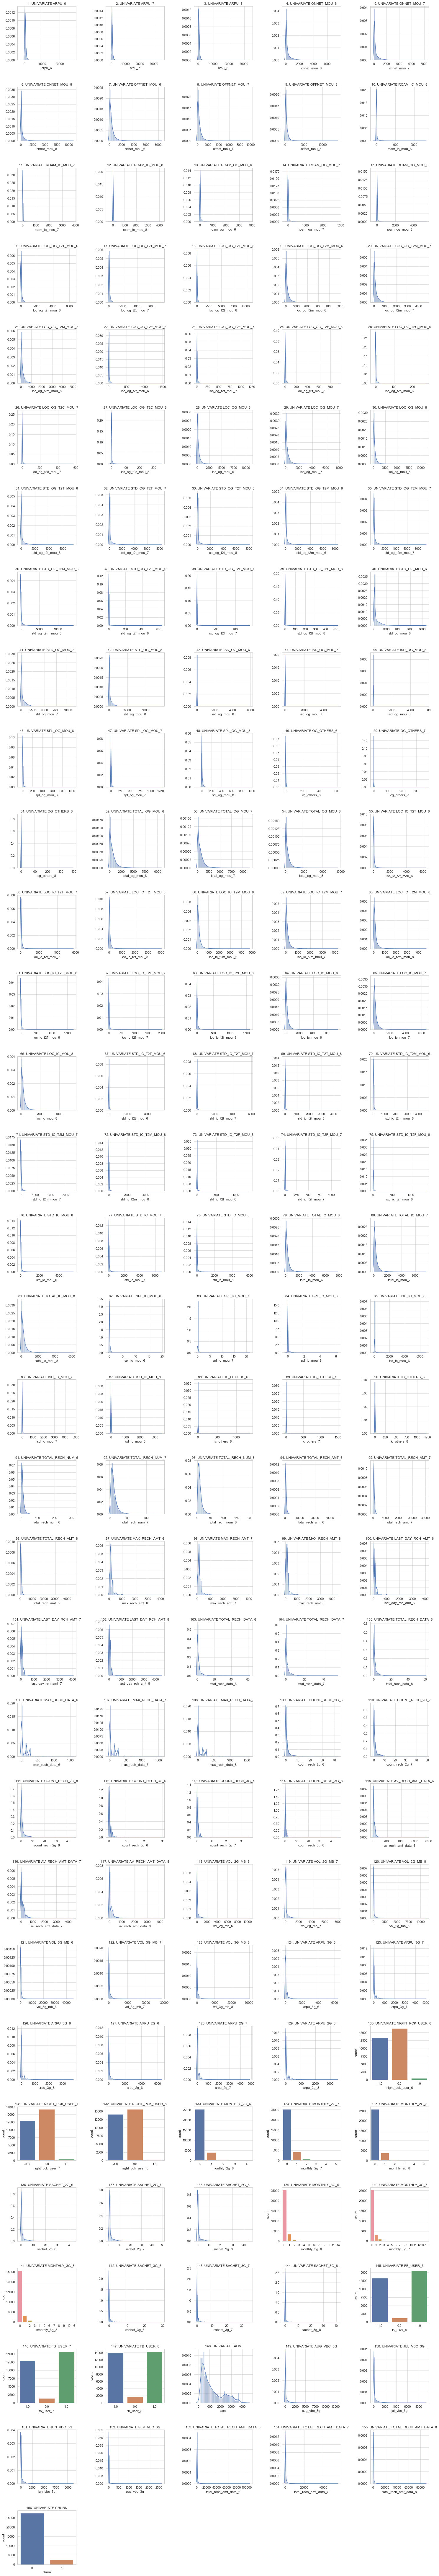

In [26]:
# Univariate Analysis

total_plots=250
count=1
for col in data.columns:    
    if col not in categorical_cols:           
        plot_graph(total_plots,5,count,'dist','Univariate '+col,data,x_value=col,y_value='',width=5,height=5)
    else:
        plot_graph(total_plots,5,count,'count','Univariate '+col,data,x_value=col,y_value='',width=5,height=5)
    count+=1

<font color="Brown">As can be seen from the plots most of the columns have outliers present which can be easily spotted from the skewness in the distribution plots. So, these outliers needs to be removed before one can proceed with building models. The outliers could be removed by dropping the respective rows, but by doing so almost the whole data is getting dropped due to which imputation techniques needs to be used.</font>

### 7. Outlier Handling

In [27]:
data_copy=data.copy()

In [28]:
# Checking for outliers
data=data_copy.copy()
for col in data.columns:
    if col not in categorical_cols:
        mean = data[col].mean()
        std = data[col].std()
        x=[0 for row in data.index if abs((data.loc[row,col]-mean)/std) >= 3]
        print(col, 'Total outliers', len(x), sep=' - ')

arpu_6 - Total outliers - 328
arpu_7 - Total outliers - 302
arpu_8 - Total outliers - 286
onnet_mou_6 - Total outliers - 626
onnet_mou_7 - Total outliers - 654
onnet_mou_8 - Total outliers - 641
offnet_mou_6 - Total outliers - 619
offnet_mou_7 - Total outliers - 570
offnet_mou_8 - Total outliers - 554
roam_ic_mou_6 - Total outliers - 487
roam_ic_mou_7 - Total outliers - 376
roam_ic_mou_8 - Total outliers - 386
roam_og_mou_6 - Total outliers - 545
roam_og_mou_7 - Total outliers - 504
roam_og_mou_8 - Total outliers - 421
loc_og_t2t_mou_6 - Total outliers - 450
loc_og_t2t_mou_7 - Total outliers - 420
loc_og_t2t_mou_8 - Total outliers - 390
loc_og_t2m_mou_6 - Total outliers - 548
loc_og_t2m_mou_7 - Total outliers - 563
loc_og_t2m_mou_8 - Total outliers - 590
loc_og_t2f_mou_6 - Total outliers - 413
loc_og_t2f_mou_7 - Total outliers - 438
loc_og_t2f_mou_8 - Total outliers - 473
loc_og_t2c_mou_6 - Total outliers - 449
loc_og_t2c_mou_7 - Total outliers - 267
loc_og_t2c_mou_8 - Total outliers -

<font color="Brown">The outlier is handled first by capping the outliers using the z score method. Out here the outlier values are basically replaced by the maximum values of the permissible range.</font>

In [29]:
# Outlier Handling using z score method and capping 
data=data_copy.copy()
for col in data.columns:
    if col not in categorical_cols:
        mean = data[col].mean()
        std = data[col].std()
        data[col]=data[col].apply(lambda x: mean+(3*std*(x/abs(x))) if abs((x-mean)/std) >= 3 else x)
        
# Checking columns for the missing data

missing_value_cols=find_missing_data(data, list(data.columns))
data.describe()

Total columns with missing data 0


arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
count 30001.00 30001.00 30001.00     30001.00     30001.00     30001.00   
mean    548.19   550.81   498.44       246.91       253.61       221.81   
std     356.62   361.12   384.49       370.41       386.42       352.39   
min    -823.43  -878.55  -945.81         0.00         0.00         0.00   
25%     309.87   309.83   231.47        20.01        18.93        15.63   
50%     481.69   480.94   427.58        92.44        90.79        80.79   
75%     699.94   698.32   661.49       290.44       290.24       239.96   
max    1940.41  2000.11  2014.48      1639.06      1707.18      1608.88   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
count      30001.00      30001.00      30001.00       30001.00       30001.00   
mean         362.22        365.56        327.09          12.45           9.25   
std          402.73        411.11        381.84          42.53          36.57   
min            0.00          0.00          0.00        -159.90        -170.49   
25%           80.71         78.54         63.19           0.00           0.00   
50%          223.11        221.06        197.52           0.00           0.00   
75%          487.94        494.01        438.89           0.00           0.00   
max         1818.67       1872.44       1777.43         246.22         241.44   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
count       30001.00       30001.00       30001.00       30001.00   
mean            9.48          20.82          15.12          15.24   
std            36.86          66.93          52.60          53.82   
min          -212.21        -229.05        -159.23        -294.30   
25%             0.00           0.00           0.00           0.00   
50%             0.00           0.00           0.00           0.00   
75%             0.00           0.00           0.00           0.00   
max           237.73         375.39         308.67         334.68   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
count          30001.00          30001.00          30001.00          30001.00   
mean              74.29             75.01             69.79            156.27   
std              133.40            135.98            126.07            198.78   
min                0.00              0.00              0.00              0.00   
25%                5.24              5.53              4.36             21.84   
50%               26.76             26.91             25.76             83.19   
75%               77.98             78.34             72.04            208.93   
max              771.03            807.43            760.66            912.90   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
count          30001.00          30001.00          30001.00          30001.00   
mean             156.79            147.56              5.54              5.62   
std              196.22            188.42             12.74             12.80   
min                0.00              0.00              0.00              0.00   
25%               23.68             19.09              0.00              0.00   
50%               84.51             81.56              0.23              0.28   
75%              208.41            196.96              4.23              4.38   
max              886.97            851.35             72.74             72.28   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
count          30001.00          30001.00          30001.00          30001.00   
mean               5.21              1.33              1.62              1.48   
std               11.72              3.76              4.69              4.26   
min                0.00            -12.81            -20.13            -19.13   
25%                0.00              0.00              0.00              0.00   
50%                0.28           

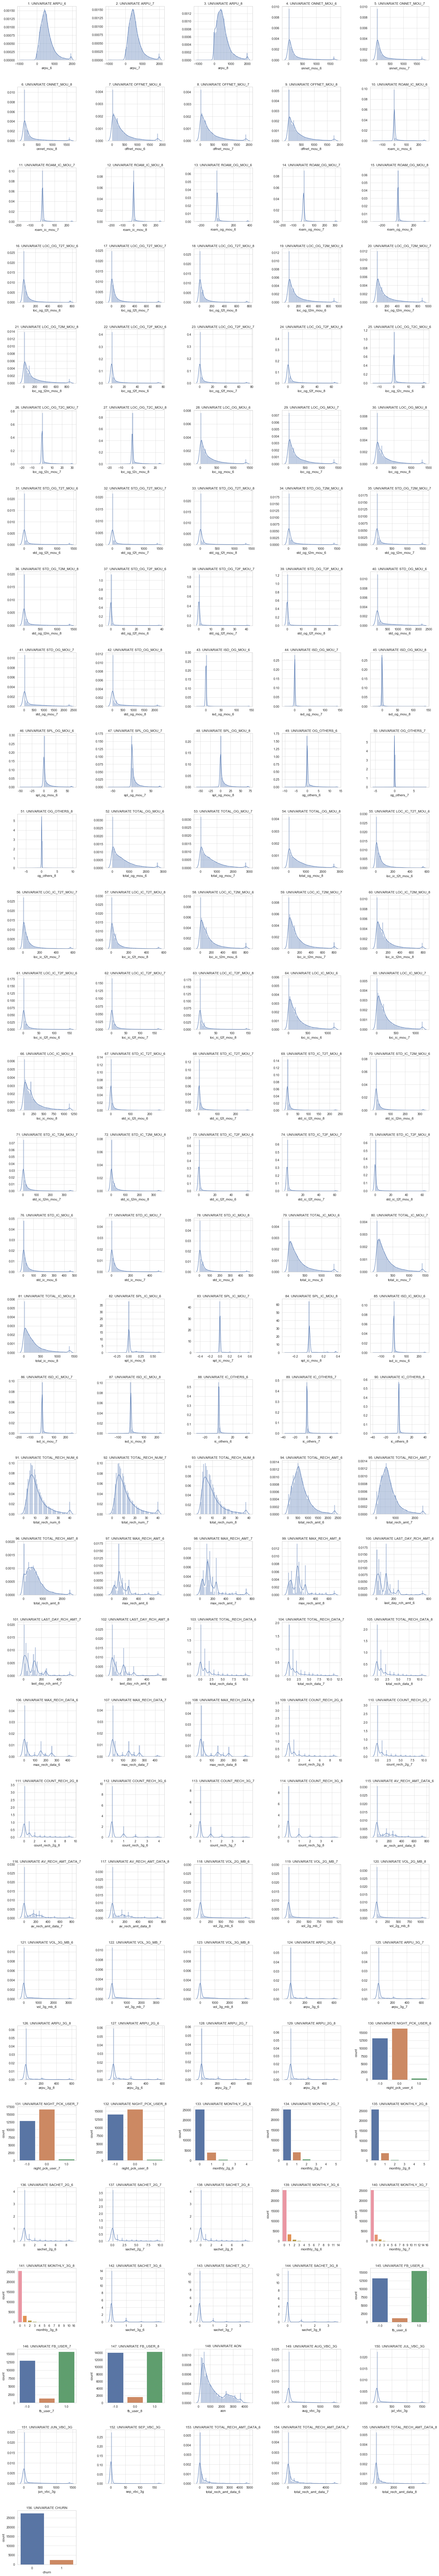

In [30]:
# Univariate Analysis

total_plots=250
count=1
for col in data.columns:    
    if col not in categorical_cols:           
        plot_graph(total_plots,5,count,'dist','Univariate '+col,data,x_value=col,y_value='',width=5,height=5)
    else:
        plot_graph(total_plots,5,count,'count','Univariate '+col,data,x_value=col,y_value='',width=5,height=5)
    count+=1

<font color="Brown">As can be seen, on capping the distribution plots are giving big bumps on both the sides of the normal curve. Thus, the outlier is handled by using the technique of imputation where the outlier values are first replaced by NA. Then these values are considered as missing data and imputed using the iterative imputer technique.</font>

In [31]:
# Outlier Handling using z score method and imputation

data=data_copy.copy()
for col in data.columns:
    if col not in categorical_cols:
        mean = data[col].mean()
        std = data[col].std()
        data[col]=data[col].apply(lambda x: np.NaN if abs((x-mean)/std) >= 3 else x)
        
# Checking columns for the missing data

missing_value_cols=find_missing_data(data, list(data.columns))

# Imputing the missing data in the above columns where outliers were removed

cols_to_impute=list(missing_value_cols.keys())
data_non_imputed=data[cols_to_impute]
n_imputations = 1
for imputation in range(n_imputations):
    imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=imputation)
    data_imputed = imputer.fit_transform(data_non_imputed)
    
data_imputed = pd.DataFrame(list(data_imputed), columns=cols_to_impute)

for col in data_imputed.columns:
    data[col]=data_imputed[col]
    
# Checking columns for the missing data

missing_value_cols=find_missing_data(data, list(data.columns))
data.describe()

Total columns with missing data 143
Total columns with missing data 0


arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
count 30001.00 30001.00 30001.00     30001.00     30001.00     30001.00   
mean    540.59   543.55   490.83       234.24       233.15       203.20   
std     336.03   340.24   364.40       344.65       335.60       305.33   
min    -810.66  -731.93  -945.81      -593.46      -209.71      -427.51   
25%     309.77   309.90   231.38        19.79        18.76        15.51   
50%     481.48   480.62   427.57        91.53        90.28        80.04   
75%     698.62   697.21   660.16       285.04       285.43       235.19   
max    2162.49  2256.51  2181.26      2433.67      2084.33      2193.12   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
count      30001.00      30001.00      30001.00       30001.00       30001.00   
mean         348.37        348.77        314.35          10.60           7.76   
std          374.48        374.78        351.74          35.03          29.30   
min         -211.54       -654.46       -545.43        -159.90        -170.49   
25%           80.43         77.89         62.99           0.00           0.00   
50%          222.13        219.59        197.05           0.00           0.00   
75%          480.11        486.16        434.86           0.00           0.00   
max         2652.58       2882.84       2511.26         416.66         396.90   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
count       30001.00       30001.00       30001.00       30001.00   
mean            7.97          20.12          14.46          14.55   
std            29.75          66.33          51.35          51.87   
min          -153.26        -229.05        -159.23        -131.38   
25%             0.00           0.00           0.00           0.00   
50%             0.00           0.00           0.00           0.00   
75%             0.00           0.00           0.00           0.00   
max           362.92        1080.75         965.89         859.95   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
count          30001.00          30001.00          30001.00          30001.00   
mean              73.63             73.91             68.98            155.15   
std              134.89            135.45            127.17            199.20   
min             -199.84           -240.99           -218.16           -610.31   
25%                5.23              5.53              4.33             21.73   
50%               26.73             26.88             25.69             82.98   
75%               77.76             78.09             71.83            207.84   
max             1286.68           1264.95           1260.94           1386.30   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
count          30001.00          30001.00          30001.00          30001.00   
mean             155.19            143.84              5.85              5.56   
std              195.72            182.65             15.93             14.41   
min            -1067.31           -673.30            -47.81            -71.29   
25%               23.58             18.96              0.00              0.00   
50%               84.24             81.29              0.23              0.28   
75%              207.78            195.89              4.21              4.34   
max             1351.46           1291.56            541.28            787.10   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
count          30001.00          30001.00          30001.00          30001.00   
mean               5.50              1.12              1.43              1.26   
std               14.83              3.01              3.95              3.49   
min              -29.52            -12.81            -20.13            -19.13   
25%                0.00              0.00              0.00              0.00   
50%                0.28           

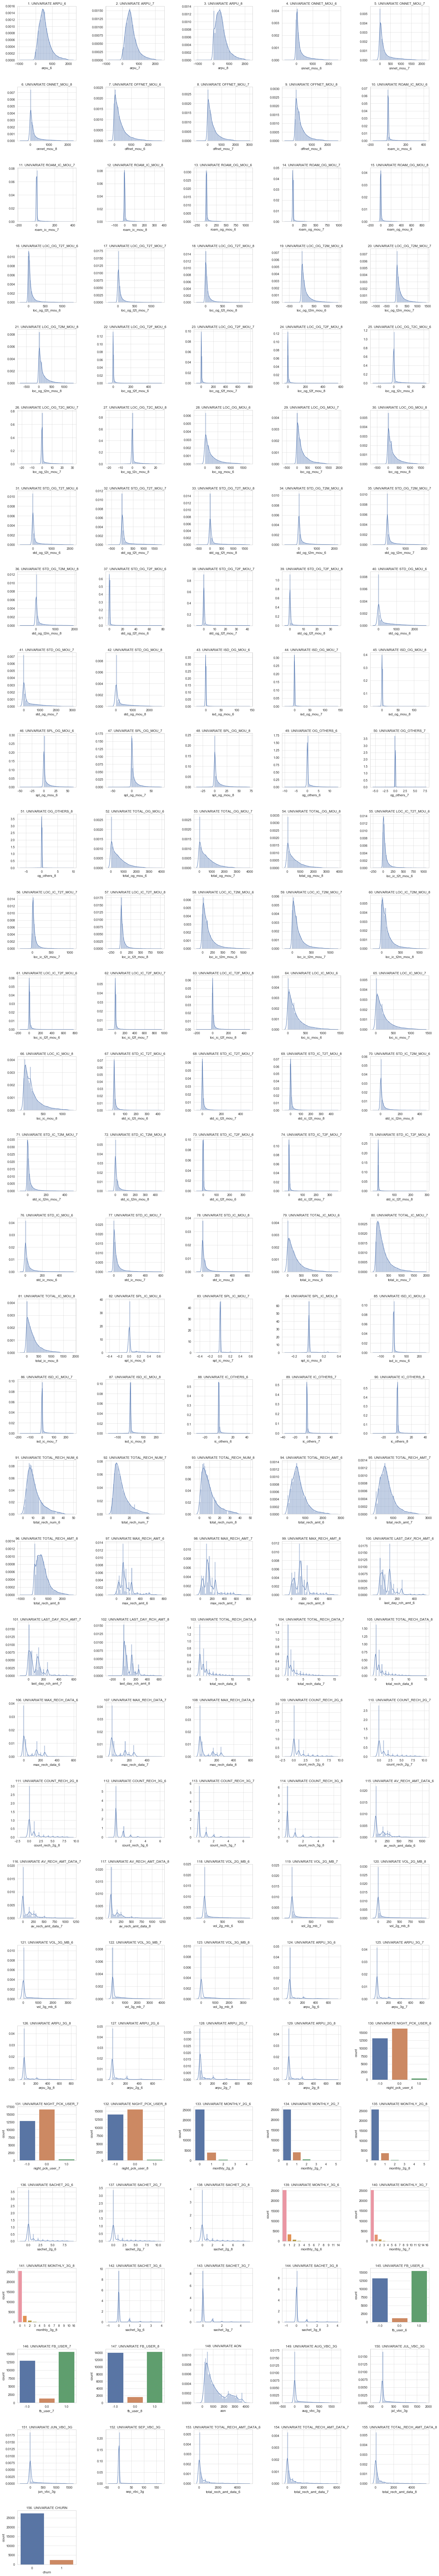

In [32]:
# Univariate Analysis

total_plots=250
count=1
for col in data.columns:    
    if col not in categorical_cols:           
        plot_graph(total_plots,5,count,'dist','Univariate '+col,data,x_value=col,y_value='',width=5,height=5)
    else:
        plot_graph(total_plots,5,count,'count','Univariate '+col,data,x_value=col,y_value='',width=5,height=5)
    count+=1

<font color="Brown">As can be seen now the distribution plots are much smoother and lees skewed as compared to the previous results.</font>

### 8. Deriving New Features

<font color="Brown">As can be seen the 6th and 7th months are the good periods and the 8th month is the action period. So, if someone wants to churn then there ought to be some change in behavior of the user in the 8th month as compared to the normal behaviour in the 6th and 7th month. So, the difference between the normal behaviour and the changed behaviour can be a very good indicator of churn. Below are the columns which have been identified to create new features.</font>

* arpu
* onnet_mou
* offnet_mou
* roam_ic_mou
* roam_og_mou
* loc_ic_mou
* loc_og_mou
* std_ic_mou
* std_og_mou
* isd_ic_mou
* isd_og_mou
* spl_ic_mou
* spl_og_mou
* ic_others
* og_others
* total_ic_mou
* total_og_mou
* total_rech_num
* max_rech_amt
* total_rech_amt
* arpu_2g
* arpu_3g
* vol_2g_mb
* vol_3g_mb
* max_rech_data
* total_rech_amt_data

In [33]:
derived_feature_list = ['arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou', 'loc_ic_mou', 'loc_og_mou', 
                        'std_ic_mou', 'std_og_mou', 'isd_ic_mou', 'isd_og_mou', 'spl_ic_mou', 'spl_og_mou', 'ic_others', 
                        'og_others', 'total_ic_mou', 'total_og_mou', 'total_rech_num', 'max_rech_amt', 'total_rech_amt', 
                        'arpu_2g', 'arpu_3g', 'vol_2g_mb', 'vol_3g_mb', 'max_rech_data', 'total_rech_amt_data']

In [34]:
# Creating the new derived columns

for col in derived_feature_list:
    derived_col = col + '_derived'
    data_col_6 = col + '_6'
    data_col_7 = col + '_7'
    data_col_8 = col + '_8'
    data[derived_col] = data[data_col_8] - data[[data_col_6, data_col_7]].mean(axis='columns')    

data['total_rech_amt_data_derived']=data['total_rech_amt_data_8']-data[['total_rech_amt_data_6', 'total_rech_amt_data_7']].mean(axis='columns')

data.drop('total_rech_amt_data_6',axis='columns',inplace=True)
data.drop('total_rech_amt_data_7',axis='columns',inplace=True)
data.drop('total_rech_amt_data_8',axis='columns',inplace=True)
data.shape

(30001, 179)

### 9. Handling Categorical Variables

In [35]:
# Checking for values in categorical variables

for col in categorical_cols.keys():
    data[col] = data[col].astype(int)
    unique_values = [value for value in data[col].unique()]
    categorical_cols[col]=unique_values
    
del(categorical_cols['churn'])
categorical_cols

{'night_pck_user_6': [0, -1, 1],
 'night_pck_user_7': [0, -1, 1],
 'night_pck_user_8': [0, -1, 1],
 'monthly_2g_6': [0, 2, 1, 3, 4],
 'monthly_2g_7': [0, 1, 2, 5, 4, 3],
 'monthly_2g_8': [0, 1, 2, 5, 3, 4],
 'monthly_3g_6': [1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14],
 'monthly_3g_7': [1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10, 16],
 'monthly_3g_8': [1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16],
 'fb_user_6': [1, -1, 0],
 'fb_user_7': [1, -1, 0],
 'fb_user_8': [1, -1, 0]}

<font color="Brown">As can be seen the categorical variables with categories less than 5 can be dummy encoded. The other remaining columns can be considered as to have been label encoded.</font>

In [36]:
#  Dummy Variables for categorical variables with less than 5 categories

dummy_cols=[col for col in categorical_cols.keys() if len(categorical_cols[col])<5]
data=pd.get_dummies(data=data, columns=dummy_cols, drop_first=True)
data.shape

(30001, 185)

### 10. Modelling

#### 10.1 Preparing Data

In [37]:
#  Creating Train Test Data

y=data.pop('churn')
x=data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100, stratify = y)
print('Train set', x_train.shape)
print('Test set', x_test.shape)

Train set (24000, 184)
Test set (6001, 184)


<font color="Brown">As can be seen that there are almost 180 odd features in the dataset. Using these many features may not yeild a better or generic model. So one has to bring down the number of features without losing much of the information. This caould be done by RFE (less efficient and requires high computation power) or by PCA (efficient and faster). Thus, PCA has been used to determine the number of features to be used for modelling.</font>

#### 10.2 Using PCA for Dimension Reduction

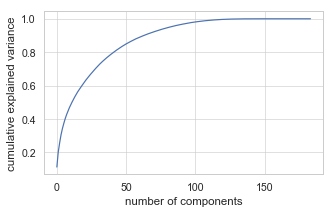

Component 5  -  34.19
Component 10  -  46.68
Component 15  -  54.78
Component 20  -  61.05
Component 25  -  66.46
Component 30  -  71.18
Component 35  -  75.25
Component 40  -  78.72
Component 45  -  81.77
Component 50  -  84.46
Component 55  -  86.73
Component 60  -  88.71
Component 65  -  90.41
Component 70  -  91.91
Component 75  -  93.28
Component 80  -  94.49
Component 85  -  95.57
Component 90  -  96.5
Component 95  -  97.3
Component 100  -  98.0
Component 105  -  98.55
Component 110  -  99.0
Component 115  -  99.34
Component 120  -  99.61
Component 125  -  99.78
Component 130  -  99.89
Component 135  -  99.95
Component 140  -  99.98
Component 145  -  100.0
Component 150  -  100.0
Component 155  -  100.0
Component 160  -  100.0
Component 165  -  100.0
Component 170  -  100.0
Component 175  -  100.0
Component 180  -  100.0


In [38]:
# Using PCA for finding the optimal number of features to be used for modelling

model_pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(svd_solver='auto', random_state=100))])
model_pca = model_pipeline.fit(x_train)
scaler = model_pipeline.named_steps['scaler']
pca = model_pipeline.named_steps['pca']

# Feature plot variance
fig = plt.figure(figsize = (5,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

cum_explained_variance=0
count=0
for explained_variance in pca.explained_variance_ratio_:
    cum_explained_variance+=explained_variance
    count+=1
    if count%5 == 0:
        print('Component', count, ' - ', round(cum_explained_variance*100,2))

<font color="Brown">As can be seen almost 90% of variance is explained by 65 components and almost 95% of variance is explained by 85 components.</font>

<font color="Brown">Now there are various classifier models available like Logistic Regression, SVM, Random Forest etc. Here we have used the Logistic Regression, SVM and Random Forest model along with PCA (for reducing the dimensions) to predict the probability of churning (or to be more specific classifying churner and non-churners). The modelling is done using pipelines (for applying the various models sequentially) and grid search cv (for the hyperparameter tuning). As the classes ar imbalanced, class weightage as balanced is being used for modelling</font>

#### 10.3 Using PCA and Logistic Regression for Modelling

In [39]:
# Using PCA and Logistic regression for modelling

pipeline_lr = Pipeline([('scaler', StandardScaler()),
                        ('pca', PCA(svd_solver='auto', random_state=100)),
                        ('lr', LogisticRegression(class_weight='balanced'))])

hyper_params_lr = {'pca__n_components': [60,80], 'lr__C':[0.1,0.5,1,5,10], 'lr__penalty': ['l1', 'l2']}

model_lr, scores_lr, cm_lr = build_model(pipeline_lr, hyper_params_lr, 'roc_auc', x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


Best Score 0.8850445669990119
Best Parameters {'lr__C': 5, 'lr__penalty': 'l1', 'pca__n_components': 80}

Confusion Matrix


array([[4505, 1008],
       [  92,  396]], dtype=int64)


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      5513
           1       0.28      0.81      0.42       488

    accuracy                           0.82      6001
   macro avg       0.63      0.81      0.65      6001
weighted avg       0.92      0.82      0.85      6001


AUC Score
0.88


<font color="Brown">As can be seen the Logistic Regression model with PCA is giving an <font color="Red"> AUC score of 88% and a sensitivity/recall of 81% </font>for the churned class.</font>

#### 10.4 Using PCA and SVM for Modelling

In [40]:
# Using PCA and Logistic regression for modelling

pipeline_svm = Pipeline([('scaler', StandardScaler()),
                         ('pca', PCA(svd_solver='auto', random_state=100)),
                         ('svm', SVC(class_weight='balanced', probability=True))])

hyper_params_svm = {'pca__n_components': [60,80], 'svm__C':[0.1,0.5,1,5,10]}

model_svm, scores_svm, cm_svm = build_model(pipeline_svm, hyper_params_svm, 'roc_auc', x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 65.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 90.0min finished


Best Score 0.8821841297451186
Best Parameters {'pca__n_components': 80, 'svm__C': 0.5}

Confusion Matrix


array([[5028,  485],
       [ 172,  316]], dtype=int64)


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      5513
           1       0.39      0.65      0.49       488

    accuracy                           0.89      6001
   macro avg       0.68      0.78      0.71      6001
weighted avg       0.92      0.89      0.90      6001


AUC Score
0.89


<font color="Brown">As can be seen the SVM model with PCA is giving an <font color="Red"> AUC score of 89% but a low sensitivity/recall of 65% </font>for the churned class. Almost half of the customers churning are not getting predicted.</font>

#### 10.5 Using PCA and Random Forest for Modelling

In [41]:
# Using PCA and Random Forest for modelling

pipeline_rf = Pipeline([('scaler', StandardScaler()),
                        ('pca', PCA(svd_solver='auto', random_state=100)),
                        ('rf', RandomForestClassifier())])

hyper_params_rf = {'pca__n_components': [60,80], 'rf__n_estimators':[50,100,300], 'rf__max_features': ['auto', 0.3], 'rf__criterion' : ['entropy', 'gini']}

model_rf, scores_rf, cm_rf = build_model(pipeline_rf, hyper_params_rf, 'roc_auc', x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 40.6min finished


Best Score 0.8932765897132476
Best Parameters {'pca__n_components': 80, 'rf__criterion': 'entropy', 'rf__max_features': 0.3, 'rf__n_estimators': 300}

Confusion Matrix


array([[5463,   50],
       [ 364,  124]], dtype=int64)


Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5513
           1       0.71      0.25      0.37       488

    accuracy                           0.93      6001
   macro avg       0.83      0.62      0.67      6001
weighted avg       0.92      0.93      0.92      6001


AUC Score
0.89


<font color="Brown">As can be seen the Random Forest model with PCA is giving an <font color="Red"> AUC score of 89% but a very very low sensitivity/recall of only 25% </font>for the churned class. It is a really bad model not able to predict even 1/4 th of the customers getting churned.</font>

#### 10.6 Selecting the Best Model for Prediction

<font color="Red">As can be concluded easily the Logistic Regression with PCA having the below hyper parmeters is the best model having the highest sensitivity/recall of 81% for the churned data.</font>

* <font color="Blue">Best Parameters C =5, penalty = 'l1' for Logistic Regression and n_components = 80 for PCA</font>

<font color="Brown">Now the whole dataset can be predicted using the best model selected.</font>

In [43]:
# Using Logistic Regression with PCA for the prediction

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('pca', PCA(svd_solver='auto', n_components=80, random_state=100)),
                     ('lr', LogisticRegression(class_weight='balanced', C=5, penalty='l1'))])

model = pipeline.fit(x_train,y_train)

# Predicting on test data
y_pred = model.predict(x)
print('Confusion Matrix')
cm=confusion_matrix(y, y_pred)
display(cm)
print('\nClassification Report')
print(classification_report(y, y_pred))
y_pred_prob = model.predict_proba(x)[:, 1]
print('\nAUC Score')
print(round(roc_auc_score(y, y_pred_prob),2))

Confusion Matrix


array([[22542,  5018],
       [  422,  2019]], dtype=int64)


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     27560
           1       0.29      0.83      0.43      2441

    accuracy                           0.82     30001
   macro avg       0.63      0.82      0.66     30001
weighted avg       0.93      0.82      0.85     30001


AUC Score
0.89


In [44]:
# Giving the probabilities of churning

display(pd.DataFrame(y_pred_prob))

0
0     0.19
1     0.46
2     0.34
3     0.11
4     0.20
5     0.14
6     0.49
7     0.50
8     0.87
9     0.55
10    0.04
11    0.47
12    0.02
13    0.67
14    0.93
15    0.66
16    0.31
17    0.87
18    0.02
19    0.09
20    0.04
21    0.66
22    0.05
23    0.05
24    0.11
25    0.21
26    0.16
27    0.79
28    0.02
29    0.56
...    ...
29971 0.27
29972 0.01
29973 0.18
29974 0.02
29975 0.35
29976 0.19
29977 0.22
29978 0.26
29979 0.18
29980 0.16
29981 0.15
29982 0.00
29983 0.02
29984 0.07
29985 0.47
29986 0.62
29987 0.15
29988 0.33
29989 0.05
29990 0.79
29991 0.03
29992 0.32
29993 0.29
29994 0.44
29995 0.33
29996 0.12
29997 0.20
29998 0.05
29999 0.01
30000 0.13

[30001 rows x 1 columns]

#### 10.7 Selecting Features for Business Insights

<font color="Brown">One can use the RFE or the Random Forest to find the top features as per their significance in the model. Here the Random Forest is used to find the top features. The RFE method is not used because the total number of features is high almost 200, which consumes a lot of time and computation power (even with step=10 i.e removing 20 features every iteration it takes hours to complete the iterations), where as Random Forest is very efficient.</font>

In [45]:
# Using Random Forest Feature Importance to select the top 20 features

number_of_features = 20
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('rf', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=100, verbose=1, criterion='entropy'))])

model = pipeline.fit(x,y)
model_rf = pipeline.named_steps['rf']
features = pd.DataFrame({'features': x.columns, 'feature_importances': model_rf.feature_importances_})
features = features.sort_values('feature_importances', ascending=False)[:number_of_features].reset_index(drop=True)
display(features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.4min finished


features  feature_importances
0           total_ic_mou_8                 0.04
1           total_og_mou_8                 0.04
2         total_rech_amt_8                 0.03
3       last_day_rch_amt_8                 0.03
4            roam_og_mou_8                 0.03
5                   arpu_8                 0.03
6             arpu_derived                 0.03
7   total_rech_amt_derived                 0.02
8             loc_ic_mou_8                 0.02
9         loc_ic_t2m_mou_8                 0.02
10          max_rech_amt_8                 0.02
11           roam_ic_mou_8                 0.02
12    total_ic_mou_derived                 0.02
13            loc_og_mou_8                 0.02
14     roam_og_mou_derived                 0.02
15        loc_og_t2m_mou_8                 0.01
16      av_rech_amt_data_8                 0.01
17     roam_ic_mou_derived                 0.01
18  total_rech_num_derived                 0.01
19    total_og_mou_derived                 0.01

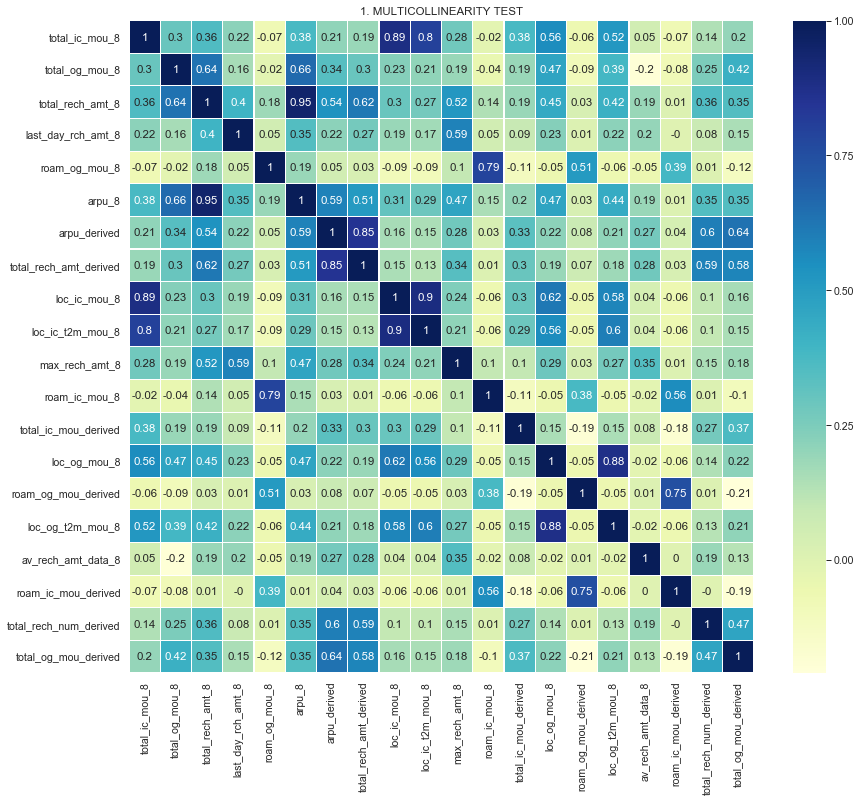

In [46]:
# Using only the top 20 features to build the model

new_features_list = list(features['features'])
plot_graph(1,1,1,'heatmap','Multicollinearity Test',data[new_features_list],width=14,height=12)

<font color="Brown">As can be seen there are still a few features which are collinear. Below is the list of collinear feature which are to be removed.</font>

* total_ic_mou_8
* arpu_8
* roam_ic_mou_8
* arpu_derived
* loc_ic_t2m_mou_8
* loc_og_t2m_mou_8
* roam_ic_mou_derived

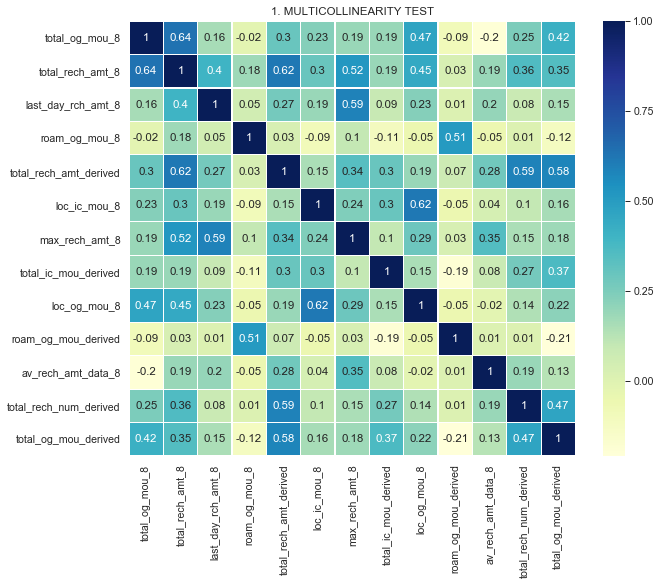

In [47]:
cols_to_remove = ['total_ic_mou_8','arpu_8','roam_ic_mou_8','arpu_derived','loc_ic_t2m_mou_8','loc_og_t2m_mou_8','roam_ic_mou_derived']
for col in cols_to_remove:
    new_features_list.remove(col)
plot_graph(1,1,1,'heatmap','Multicollinearity Test',data[new_features_list],width=10,height=8)

In [50]:
# Building the model with Logistic Regression using the top 13 features selected

x_train, x_test, y_train, y_test = train_test_split(data[new_features_list], y, test_size = 0.2, random_state = 100, stratify = y)

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('lr', LogisticRegression(class_weight='balanced', C=5, penalty='l1'))])

model = pipeline.fit(x_train,y_train)

# Predicting on test data
y_pred = model.predict(data[new_features_list])
print('Confusion Matrix')
cm=confusion_matrix(y, y_pred)
display(cm)
print('\nClassification Report')
print(classification_report(y, y_pred))
y_pred_prob = model.predict_proba(data[new_features_list])[:, 1]
print('\nAUC Score')
print(round(roc_auc_score(y, y_pred_prob),2))

Confusion Matrix


array([[22095,  5465],
       [  423,  2018]], dtype=int64)


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27560
           1       0.27      0.83      0.41      2441

    accuracy                           0.80     30001
   macro avg       0.63      0.81      0.64     30001
weighted avg       0.92      0.80      0.84     30001


AUC Score
0.87


<font color="Brown">As can be seen the Logistic Regression model with 13 features is giving similar accuracy (87%) and sensitivity/recall for the churned class (83%).</font>

In [51]:
# Finding the co-efficients for the features selected to get some business insights

display(pd.DataFrame(pipeline.named_steps['lr'].coef_, columns=new_features_list, index=['Co-efficient']).T)

Co-efficient
total_og_mou_8                 -0.47
total_rech_amt_8                0.13
last_day_rch_amt_8             -0.54
roam_og_mou_8                   0.33
total_rech_amt_derived         -0.40
loc_ic_mou_8                   -0.37
max_rech_amt_8                  0.09
total_ic_mou_derived           -0.30
loc_og_mou_8                   -0.27
roam_og_mou_derived            -0.09
av_rech_amt_data_8             -0.77
total_rech_num_derived         -0.28
total_og_mou_derived           -0.06

* Of the 13 parameters 10 parameters are showing negative coefficient which shows a general user behaviour from good phase to action phase before switching to other network.

* The outgoing calls and incoming calls are decreasing giving a indication that the customer is not happy. There can be a number of reasons why the customer can be unhappy.

* The increase the reacharge amounts along with a decrease in the call periods suggests that may be there had been a hike in the prices of the service due to which the customer is unhappy. Thus, the operator may come up with some plans to decrease the service charges.

* Increase in the roaming outgoing suggests that the person may have shifted to some other city and planning to take local network services. Thus, the operator may come up with some plans to decrease the roaming charges.